In [1]:
import conx as cx

Using TensorFlow backend.
Conx, version 3.6.6


In [2]:
faces = cx.Dataset.get('cmu_faces_half_size')

In [3]:
faces.info()

**Dataset**: CMU Faces, half-size


Original source: http://archive.ics.uci.edu/ml/datasets/cmu+face+images

**Information**:
   * name    : CMU Faces, half-size
   * length  : 624

**Input Summary**:
   * shape  : (60, 64)
   * range  : (0.0, 1.0)

**Target Summary**:
   * shape  : (4,)
   * range  : (0, 1)



In [4]:
faces.summary()

_________________________________________________________________
CMU Faces, half-size:
Patterns    Shape                 Range                         
inputs      (60, 64)              (0.0, 1.0)                    
targets     (4,)                  (0, 1)                        
Total patterns: 624
   Training patterns: 624
   Testing patterns: 0
_________________________________________________________________


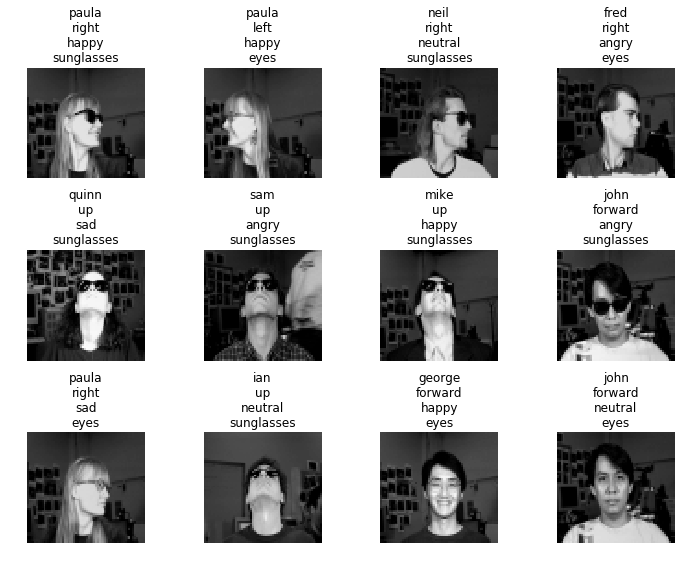

In [5]:
faces.shuffle()
cx.view(faces.inputs[0:12],
        labels=[x.replace("_", "\n") for x in faces.labels[0:12]],
        layout=(3,4),
        spacing=0.50,
        scale=3)

In [6]:
set([label.split("_")[0] for label in faces.labels])

{'alex',
 'bob',
 'carl',
 'dave',
 'emma',
 'fred',
 'george',
 'henry',
 'ian',
 'john',
 'keith',
 'larry',
 'mike',
 'neil',
 'owen',
 'paula',
 'quinn',
 'rose',
 'sam',
 'tom'}

In [7]:
set([label.split("_")[1] for label in faces.labels])

{'forward', 'left', 'right', 'up'}

In [8]:
set([label.split("_")[2] for label in faces.labels])

{'angry', 'happy', 'neutral', 'sad'}

In [9]:
set([label.split("_")[3] for label in faces.labels])
#This differs for me from the example

{'eyes', 'sunglasses'}

In [10]:
faces.labels.select(lambda i, dataset: dataset.labels[i].split("_")[3] == "sunglasse", index=True)
#This differs for me from the example

[]

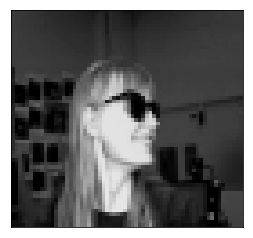

In [11]:
cx.view(faces.inputs[0])

In [12]:
faces.targets[0]

[0, 0, 0, 1]

In [13]:
cx.shape(faces.inputs[0])

(60, 64)

In [14]:
net = cx.Network("Pose Recognizer")
#We are recognizing which way the person is facing. 
net.add(cx.Layer('input', cx.shape(faces.inputs[0])),
        cx.FlattenLayer("flatten"),
        cx.Layer('hidden', 3, activation='sigmoid'),
        cx.Layer('output', 4, activation='sigmoid'))

net.connect()

net.compile(loss='mean_squared_error', optimizer="SGD", lr=0.2, momentum=0.1)

In [15]:
net.set_dataset(faces)
faces.split(0.30)  # reserve 30% of input data for testing set
faces.summary()

_________________________________________________________________
CMU Faces, half-size:
Patterns    Shape                 Range                         
inputs      (60, 64)              (0.0, 1.0)                    
targets     (4,)                  (0, 1)                        
Total patterns: 624
   Training patterns: 437
   Testing patterns: 187
_________________________________________________________________


In [16]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 60, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3840)              0         
_________________________________________________________________
hidden (Dense)               (None, 3)                 11523     
_________________________________________________________________
output (Dense)               (None, 4)                 16        
Total params: 11,539
Trainable params: 11,539
Non-trainable params: 0
_________________________________________________________________


In [17]:
net.propagate(faces.inputs[3])

[0.45903030037879944,
 0.5590590834617615,
 0.6369393467903137,
 0.49729883670806885]

In [18]:
net.dashboard()
#Very evident that this net recognizes facing direction
#Left most output is left facing, right is right, and second-from-left is facing forward
# second-from-right is looking up. 

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

<IPython.core.display.Javascript object>

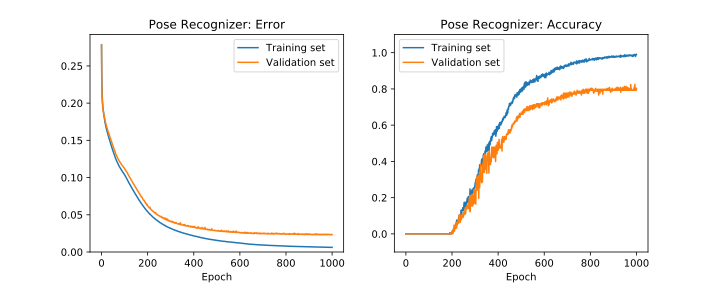

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
# 1000 |   0.00619 |   0.99083 |   0.02320 |   0.80319 


In [19]:
net.train(1000, accuracy=1.0, tolerance=0.2, report_rate=5)

In [20]:
net.evaluate()

{'loss': 0.00616841068495602,
 'acc': 0.9908466820585918,
 'val_loss': 0.023299832654031204,
 'val_acc': 0.8021390339269995}

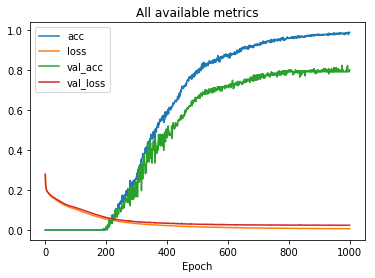

In [21]:
net.plot("all", title="All available metrics")

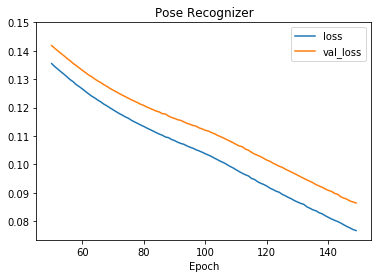

In [22]:
net.plot(['loss', 'val_loss'], ymax=0.15, start=50, end=150)

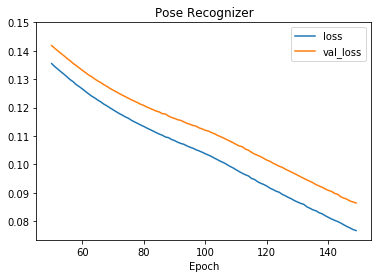

In [23]:
net.plot(['.*loss'], ymax=0.15, start=50, end=150)

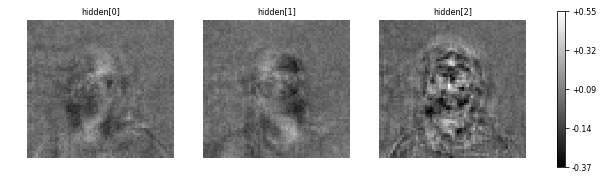

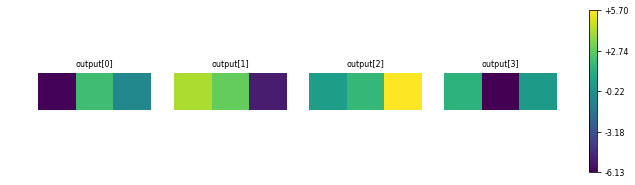

In [24]:
net.plot_layer_weights('hidden', vshape=faces.inputs.shape[0])
net.plot_layer_weights('output', colormap='viridis')

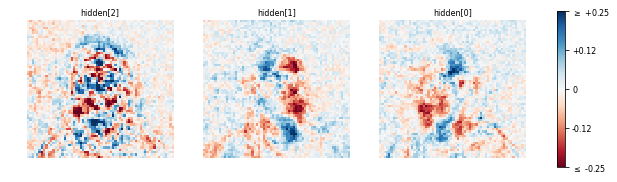

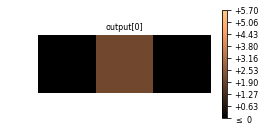

In [25]:
# colorbar colors or values can be easily changed
net.plot_layer_weights('hidden', vshape=net.dataset.inputs.shape[0],
                       units=(2,1,0), colormap="RdBu", wrange=(-0.25, 0.25))
net.plot_layer_weights('output', units=0, wmin=0, colormap="copper", ticks=10)

In [26]:
net.show_unit_weights('output', 0)

-6.02  2.06 -0.61 


In [27]:
net.get_weights("output")

[[[-6.01511287689209,
   4.236996650695801,
   0.4626159369945526,
   1.5113486051559448],
  [2.0647103786468506,
   2.9005112648010254,
   1.7291897535324097,
   -6.133796215057373],
  [-0.6113260388374329,
   -5.171404838562012,
   5.696839809417725,
   0.29599905014038086]],
 [0.7788110375404358,
  -4.898872375488281,
  -5.162761211395264,
  1.2355272769927979]]

In [28]:
##TRAINING SOMETHING ELSE
faces2 = cx.Dataset.get('cmu_faces_half_size')

In [29]:
net2 = cx.Network("Person Recognizer")


net2.add(cx.Layer("input", (60,64,1), colormap="gray"),
        cx.Conv2DLayer("conv2D_1", 16, (5,5), activation="relu", dropout=0.20),
        cx.MaxPool2DLayer("maxpool1", (2,2)),
        cx.Conv2DLayer("conv2D_2", 32, (5,5), activation="relu", dropout=0.20),
        cx.MaxPool2DLayer("maxpool2", (2,2)),
        cx.FlattenLayer("flat"),
        cx.Layer("hidden", 30, activation='relu'),
        cx.Layer("output", 20, activation='softmax'))

net2.connect()

net2.compile(loss='categorical_crossentropy', optimizer="RMSprop")

In [30]:
# import numpy as np
net2.dataset.clear()
faces2.shuffle()
facedict = {}
faces2.inputs.reshape(0,(60,64,1))
#print(faces2.inputs)
#faces2.targets = []
#newset = []
#newinputs = faces2.inputs   #INPUTS
# #faces2.targets.reshape(20)
def buildlist(z):
    listo = [0]*20
    listo[z] = 1
    return listo

counter = 0
for i,face in enumerate(faces2.labels):
    ft = face.split("_")[0]
    #print(ft)
    if ft not in facedict:
        facedict[ft] = counter
        counter += 1
    #faces2.targets.append(buildlist(facedict[ft]))
    net2.dataset.append(faces2.inputs[i],buildlist(facedict[ft]))
    #if 0 == i%10:
        #print(faces2.inputs[i])
        #print(buildlist(facedict[ft]))
    #newset.append((faces.inputs[i],faces2.targets[i]))

#print(faces2.targets)
#faces2.targets = newset
#faces2.targets = faces2.targets[:624]
# len(faces2.targets)
# faces2.targets= np.array(faces2.targets) #TARGETS
# print(faces2.targets[623])
# faces2.targets[0]
net2.dataset.info()

**Dataset**: Dataset for Person Recognizer

**Information**:
   * name    : None
   * length  : 624

**Input Summary**:
   * shape  : (60, 64, 1)
   * range  : (0.0, 1.0)

**Target Summary**:
   * shape  : (20,)
   * range  : (0.0, 1.0)



In [31]:
net2.dataset.split(187)
net2.dataset.split()


(437, 187)

In [32]:
net2.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

<IPython.core.display.Javascript object>

In [33]:
net2.propagate(faces2.inputs[2])

[0.04428107291460037,
 0.05809847265481949,
 0.047236815094947815,
 0.04620245844125748,
 0.045299727469682693,
 0.05116556957364082,
 0.04173773527145386,
 0.04643088951706886,
 0.05074073001742363,
 0.0475863479077816,
 0.04891122877597809,
 0.049225855618715286,
 0.052506402134895325,
 0.04532851651310921,
 0.05962926149368286,
 0.05477782338857651,
 0.045800115913152695,
 0.05736491456627846,
 0.05791360139846802,
 0.049762461334466934]

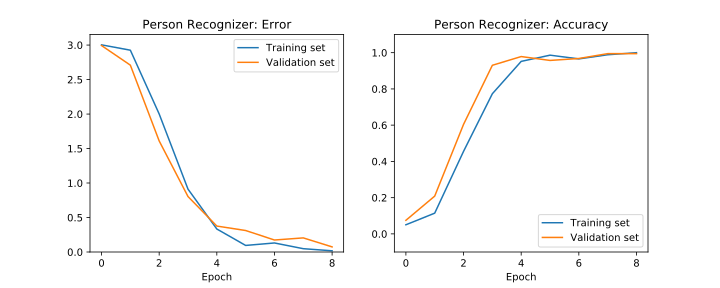

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#    8 |   0.01736 |   1.00000 |   0.07380 |   0.99465 


In [34]:
net2.reset()
net2.train(1000, accuracy=1.0, tolerance=0.2, report_rate=5)
#net2.train(epochs=10000)

In [35]:
net2.evaluate()

{'loss': 0.04894316719005255,
 'acc': 0.9954233409610984,
 'val_loss': 0.07380357320933419,
 'val_acc': 0.9946524064171123}

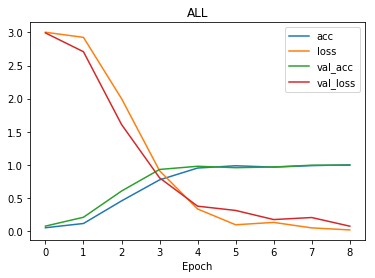

In [36]:
net2.plot("all",title="ALL")

In [37]:
results = [net2.propagate(img) for img in net2.dataset.test_inputs]
classifications = [cx.argmax(r) for r in results]
correct_answers = [cx.argmax(t) for t in net2.dataset.test_targets]
print(len(correct_answers))

187


In [38]:
wrong = [i for i in range(len(classifications)) if classifications[i] != correct_answers[i]]


In [39]:
print('Network classified the following', len(wrong), 'test inputs incorrectly:')
print(wrong)

Network classified the following 1 test inputs incorrectly:
[146]


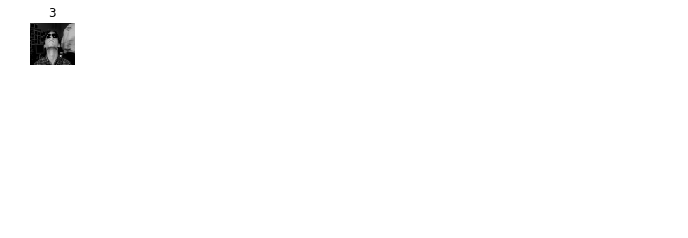

In [40]:
misclassifications = [classifications[i] for i in wrong]
cx.view(net2.dataset.test_inputs[wrong], labels=misclassifications, layout=(3,10), spacing=0.5)

In [41]:
faces2 = cx.Dataset.get('cmu_faces_half_size')
#Again with sunglasses this time

In [42]:
net2 = cx.Network("Sunglasses Recognizer")


net2.add(cx.Layer("input", (60,64,1), colormap="gray"),
        cx.Conv2DLayer("conv2D_1", 16, (5,5), activation="relu", dropout=0.20),
        cx.MaxPool2DLayer("maxpool1", (2,2)),
        cx.Conv2DLayer("conv2D_2", 32, (5,5), activation="relu", dropout=0.20),
        cx.MaxPool2DLayer("maxpool2", (2,2)),
        cx.FlattenLayer("flat"),
        cx.Layer("hidden", 30, activation='relu'),
        cx.Layer("output", 2, activation='softmax'))

net2.connect()

net2.compile(loss='categorical_crossentropy', optimizer="RMSprop")

In [43]:
net2.dataset.clear()
faces2.shuffle()
facedict = {}
faces2.inputs.reshape(0,(60,64,1))
#print(faces2.inputs)
#faces2.targets = []
#newset = []
#newinputs = faces2.inputs   #INPUTS
# #faces2.targets.reshape(20)
def buildlist(z):
    listo = [0]*20
    listo[z] = 1
    return listo

counter = 0
for i,face in enumerate(faces2.labels):
    glasses = face.split("_")[3]
    #print(ft)
    if glasses == "sunglasses":
         net2.dataset.append(faces2.inputs[i],[0,1])
    else:
         net2.dataset.append(faces2.inputs[i],[1,0])

#print(faces2.targets)
#faces2.targets = newset
#faces2.targets = faces2.targets[:624]
# len(faces2.targets)
# faces2.targets= np.array(faces2.targets) #TARGETS
# print(faces2.targets[623])
# faces2.targets[0]
net2.dataset.info()

**Dataset**: Dataset for Sunglasses Recognizer

**Information**:
   * name    : None
   * length  : 624

**Input Summary**:
   * shape  : (60, 64, 1)
   * range  : (0.0, 1.0)

**Target Summary**:
   * shape  : (2,)
   * range  : (0.0, 1.0)



In [44]:
net2.dataset.split(187)
net2.dataset.split()

(437, 187)

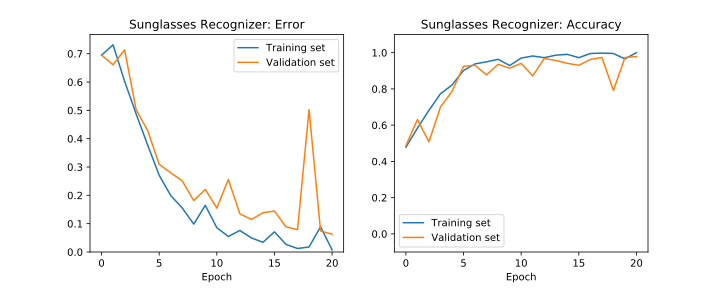

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   20 |   0.00734 |   1.00000 |   0.06250 |   0.97861 


In [45]:
net2.reset()
net2.train(1000, accuracy=1.0, tolerance=0.2, report_rate=5)

In [46]:
net2.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

<IPython.core.display.Javascript object>

Network classified the following 4 test inputs incorrectly:
[18, 29, 107, 112]


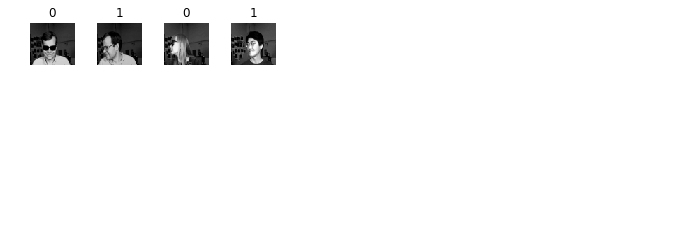

In [47]:
results = [net2.propagate(img) for img in net2.dataset.test_inputs]
classifications = [cx.argmax(r) for r in results]
correct_answers = [cx.argmax(t) for t in net2.dataset.test_targets]
wrong = [i for i in range(len(classifications)) if classifications[i] != correct_answers[i]]
print('Network classified the following', len(wrong), 'test inputs incorrectly:')
print(wrong)
misclassifications = [classifications[i] for i in wrong]
cx.view(net2.dataset.test_inputs[wrong], labels=misclassifications, layout=(3,10), spacing=0.5)